In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [2]:
DATA = "../data/tsa_外国人人口.csv"
df = pd.read_csv(DATA)
df = df.set_index("year")
df.index = pd.to_datetime(df.index)

In [3]:
display(df.head())
display(df.tail())

,総数_総数,総数_区部,総数_千代田区,総数_中央区,総数_港区,総数_新宿区,総数_文京区,総数_台東区,総数_墨田区,総数_江東区,...,その他_郡部,その他_瑞穂町,その他_日の出町,その他_檜原村,その他_奥多摩町,その他_島部,その他_大島支庁,その他_三宅支庁,その他_八丈支庁,その他_小笠原支庁
year,,,,,,,,,,,,,,,,,,,,,
1979-01-01,110862.0,93328.0,3188.0,459.0,7563.0,5488.0,2669.0,3098.0,1821.0,3653.0,...,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0
1980-01-01,112523.0,94819.0,3309.0,470.0,7718.0,6036.0,2745.0,3060.0,1849.0,3691.0,...,1.0,0.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0,0.0
1981-01-01,114449.0,96434.0,3328.0,441.0,8258.0,6138.0,2825.0,3054.0,1889.0,3880.0,...,2.0,1.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0,0.0
1982-01-01,117971.0,99615.0,3400.0,484.0,8638.0,6779.0,2804.0,3059.0,2014.0,4073.0,...,5.0,4.0,1.0,0.0,0.0,5.0,3.0,0.0,2.0,0.0
1983-01-01,121663.0,103002.0,3470.0,556.0,9171.0,7339.0,2996.0,3089.0,2150.0,4190.0,...,4.0,4.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0


,総数_総数,総数_区部,総数_千代田区,総数_中央区,総数_港区,総数_新宿区,総数_文京区,総数_台東区,総数_墨田区,総数_江東区,...,その他_郡部,その他_瑞穂町,その他_日の出町,その他_檜原村,その他_奥多摩町,その他_島部,その他_大島支庁,その他_三宅支庁,その他_八丈支庁,その他_小笠原支庁
year,,,,,,,,,,,,,,,,,,,,,
2021-01-01,546436.0,456873.0,3057.0,8291.0,18718.0,37827.0,10333.0,14788.0,12431.0,30392.0,...,182.0,161.0,17.0,0.0,4.0,15.0,4.0,3.0,6.0,2.0
2022-01-01,517881.0,430444.0,2814.0,8062.0,16929.0,33907.0,9746.0,13896.0,11892.0,29275.0,...,194.0,168.0,21.0,1.0,4.0,15.0,5.0,3.0,6.0,1.0
2023-01-01,581112.0,485444.0,3353.0,9324.0,19339.0,40279.0,12390.0,16026.0,13758.0,33391.0,...,231.0,201.0,21.0,1.0,8.0,17.0,6.0,3.0,6.0,2.0
2024-01-01,647416.0,542864.0,3858.0,10370.0,21278.0,43897.0,14036.0,18485.0,15663.0,37006.0,...,261.0,228.0,24.0,1.0,8.0,22.0,9.0,2.0,9.0,2.0
2025-01-01,721223.0,605506.0,4108.0,12553.0,22614.0,48097.0,15923.0,20332.0,16980.0,39561.0,...,290.0,249.0,28.0,1.0,12.0,30.0,12.0,3.0,14.0,1.0


<Figure size 1200x800 with 0 Axes>

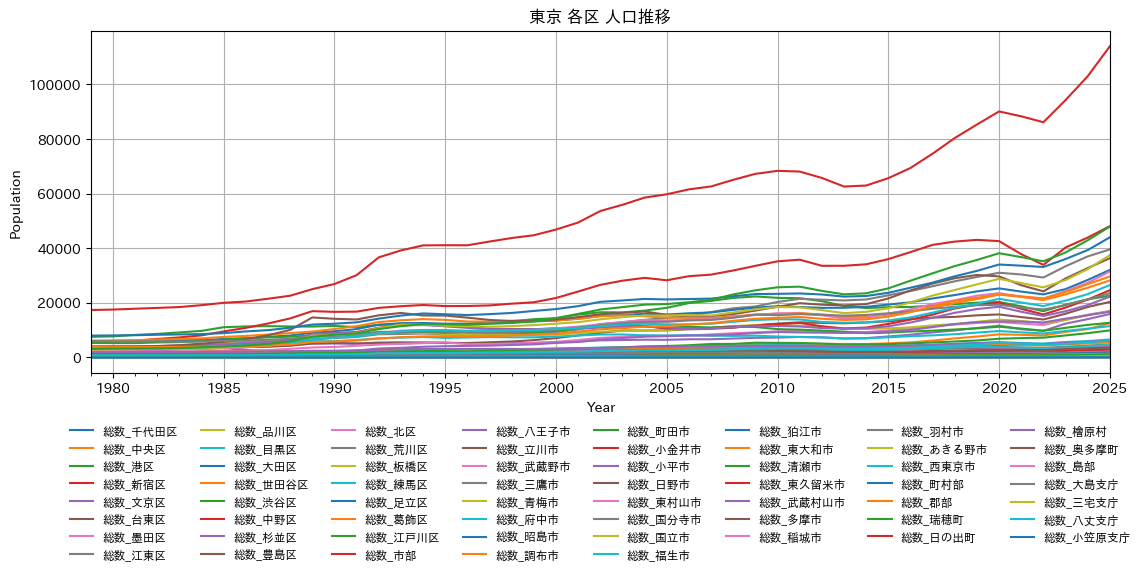

In [4]:
cols = df.columns
cols= cols[2:63]

plt.figure(figsize=(12,8))
ax = df[cols].plot(figsize=(12,6))
plt.title("東京 各区 人口推移")
plt.xlabel("Year")
plt.ylabel("Population")
plt.grid(True)

ax.legend(ncol=8, loc='upper center', bbox_to_anchor=(0.5, -0.12), fontsize='small', frameon=False)
plt.tight_layout()
plt.savefig("../data/東京_各区_人口推移.png")
plt.show()

In [5]:
df_trim= df[cols[2:63]]

In [6]:
df_trim.isna().sum()

総数_港区       0
総数_新宿区      0
総数_文京区      0
総数_台東区      0
総数_墨田区      0
総数_江東区      0
総数_品川区      0
総数_目黒区      0
総数_大田区      0
総数_世田谷区     0
総数_渋谷区      0
総数_中野区      0
総数_杉並区      0
総数_豊島区      0
総数_北区       0
総数_荒川区      0
総数_板橋区      0
総数_練馬区      0
総数_足立区      0
総数_葛飾区      0
総数_江戸川区     0
総数_市部       0
総数_八王子市     0
総数_立川市      0
総数_武蔵野市     0
総数_三鷹市      0
総数_青梅市      0
総数_府中市      0
総数_昭島市      0
総数_調布市      0
総数_町田市      0
総数_小金井市     0
総数_小平市      0
総数_日野市      0
総数_東村山市     0
総数_国分寺市     0
総数_国立市      0
総数_福生市      0
総数_狛江市      0
総数_東大和市     0
総数_清瀬市      0
総数_東久留米市    0
総数_武蔵村山市    0
総数_多摩市      0
総数_稲城市      0
総数_羽村市      0
総数_あきる野市    0
総数_西東京市     0
総数_町村部      0
総数_郡部       0
総数_瑞穂町      0
総数_日の出町     0
総数_檜原村      0
総数_奥多摩町     0
総数_島部       0
総数_大島支庁     0
総数_三宅支庁     0
総数_八丈支庁     0
総数_小笠原支庁    0
dtype: int64

In [7]:
df_trim_diff = df_trim.diff()
df_trim_diff.head()

,総数_港区,総数_新宿区,総数_文京区,総数_台東区,総数_墨田区,総数_江東区,総数_品川区,総数_目黒区,総数_大田区,総数_世田谷区,...,総数_郡部,総数_瑞穂町,総数_日の出町,総数_檜原村,総数_奥多摩町,総数_島部,総数_大島支庁,総数_三宅支庁,総数_八丈支庁,総数_小笠原支庁
year,,,,,,,,,,,,,,,,,,,,,
1979-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-01,155.0,548.0,76.0,-38.0,28.0,38.0,66.0,-35.0,22.0,55.0,...,10.0,7.0,0.0,1.0,2.0,-3.0,2.0,-1.0,-3.0,-1.0
1981-01-01,540.0,102.0,80.0,-6.0,40.0,189.0,1.0,123.0,82.0,76.0,...,-3.0,-1.0,2.0,-1.0,-3.0,3.0,0.0,3.0,0.0,0.0
1982-01-01,380.0,641.0,-21.0,5.0,125.0,193.0,136.0,16.0,168.0,251.0,...,27.0,13.0,5.0,0.0,9.0,11.0,0.0,3.0,3.0,5.0
1983-01-01,533.0,560.0,192.0,30.0,136.0,117.0,47.0,176.0,52.0,193.0,...,12.0,6.0,2.0,0.0,4.0,-11.0,-2.0,0.0,-4.0,-5.0


<Figure size 1200x800 with 0 Axes>

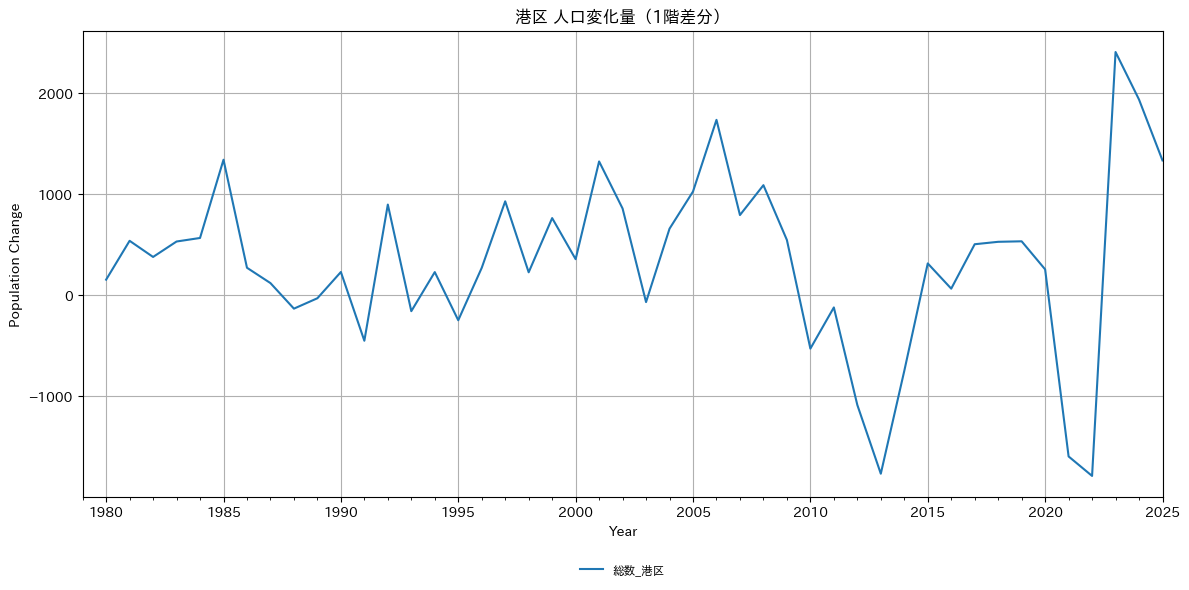

In [8]:
plt.figure(figsize=(12,8))
ax = df_trim_diff[["総数_港区"]].plot(figsize=(12,6))
plt.title("港区 人口変化量（1階差分）")
plt.xlabel("Year")
plt.ylabel("Population Change")
plt.grid(True)
ax.legend(ncol=8, loc='upper center', bbox_to_anchor=(0.5, -0.12), fontsize='small', frameon=False)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

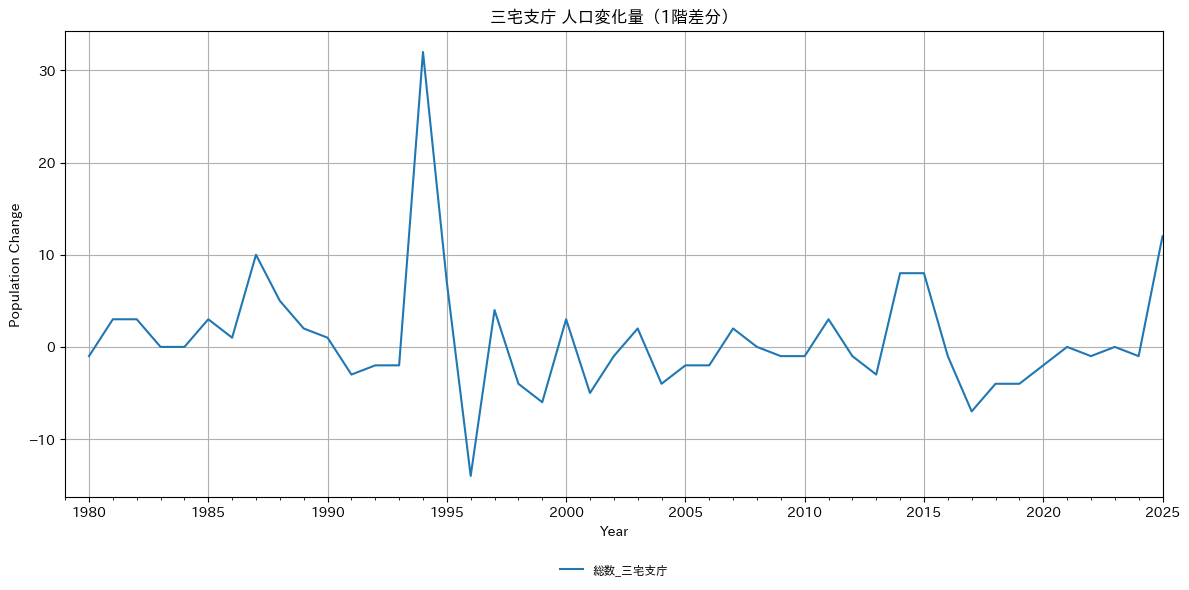

In [9]:
plt.figure(figsize=(12,8))
ax = df_trim_diff[["総数_三宅支庁"]].plot(figsize=(12,6))
plt.title("三宅支庁 人口変化量（1階差分）")
plt.xlabel("Year")
plt.ylabel("Population Change")
plt.grid(True)
ax.legend(ncol=8, loc='upper center', bbox_to_anchor=(0.5, -0.12), fontsize='small', frameon=False)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

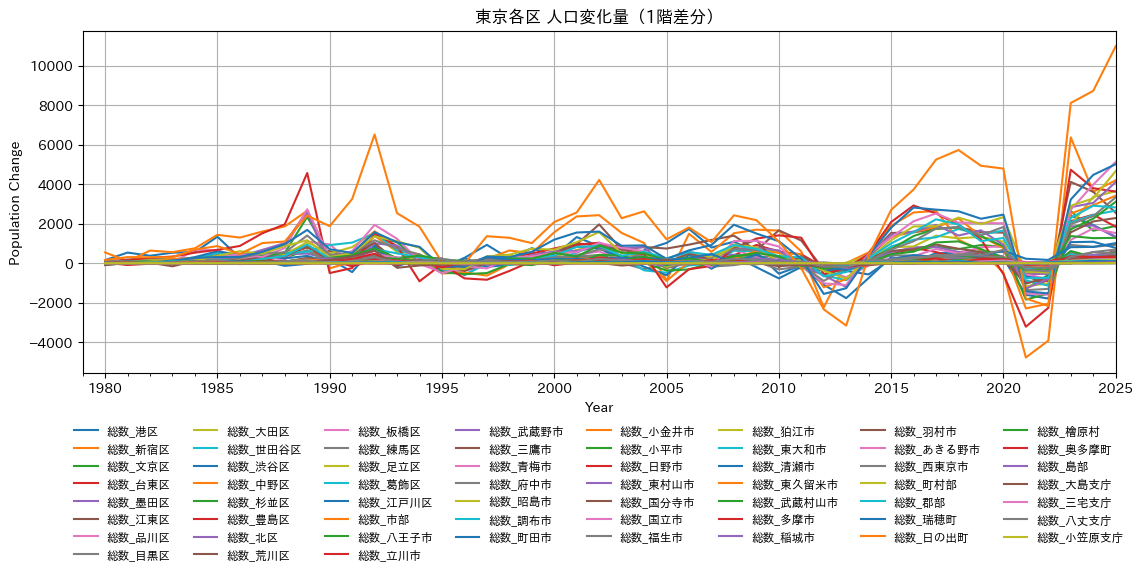

In [10]:
df_trim_diff = df_trim.diff()

plt.figure(figsize=(12,8))
ax = df_trim_diff.plot(figsize=(12,6))
plt.title("東京各区 人口変化量（1階差分）")
plt.xlabel("Year")
plt.ylabel("Population Change")
plt.grid(True)
ax.legend(ncol=8, loc='upper center', bbox_to_anchor=(0.5, -0.12), fontsize='small', frameon=False)
plt.tight_layout()
plt.show()

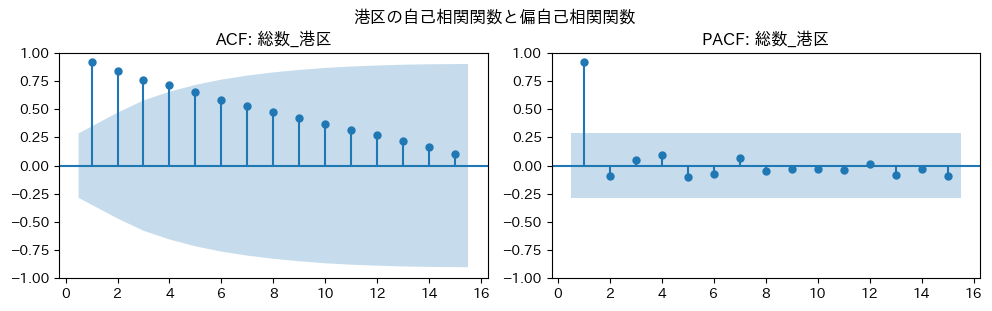

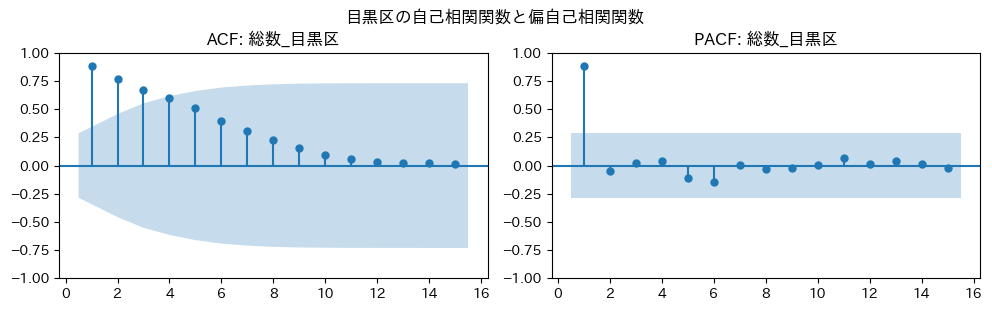

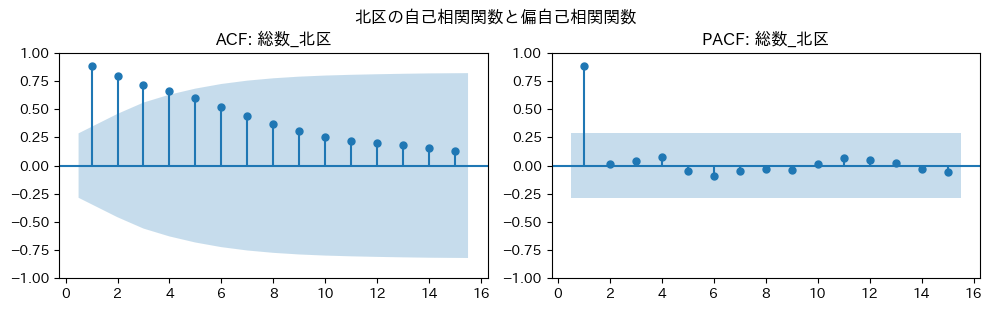

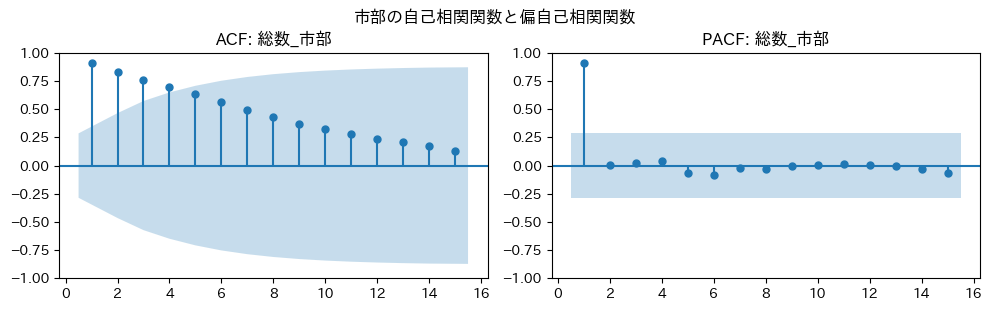

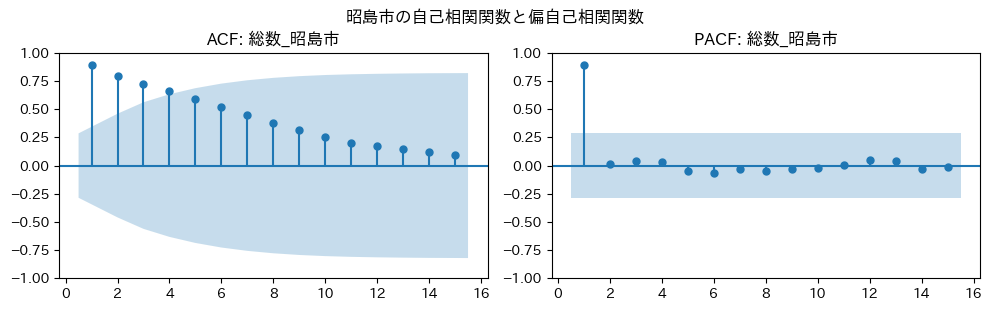

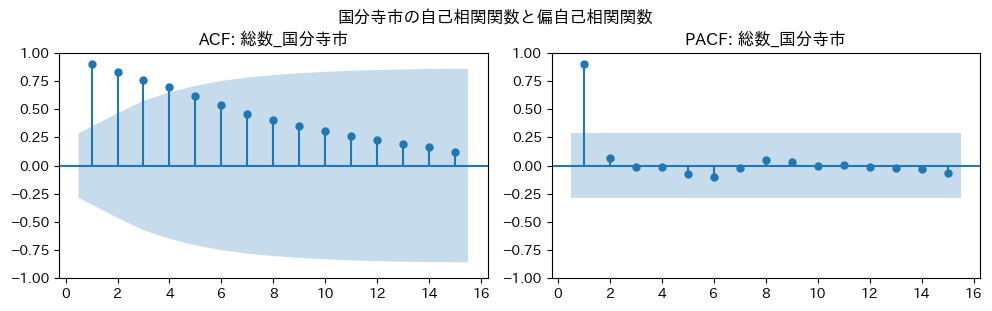

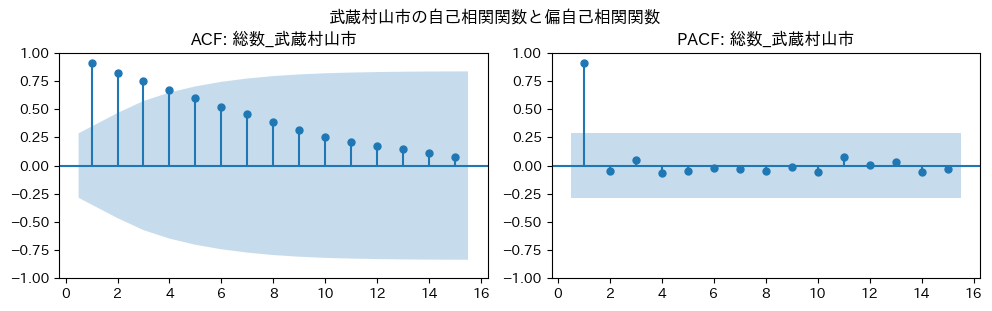

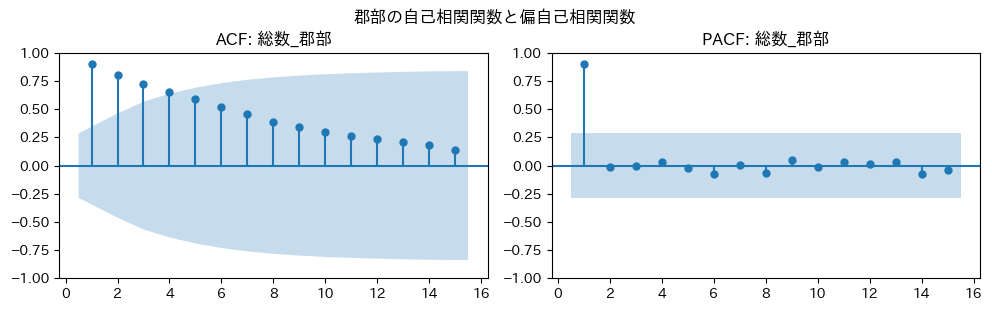

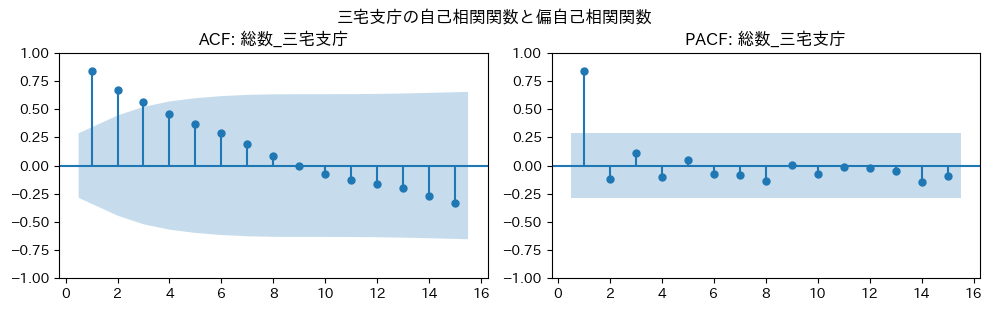

In [11]:
for i, col in enumerate(df_trim.columns[::7]):
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    plot_acf(df_trim[col], ax=axes[0], lags=15, zero=False)
    axes[0].set_title(f"ACF: {col}")
    plot_pacf(df_trim[col], ax=axes[1], lags=15, zero=False)
    axes[1].set_title(f"PACF: {col}")
    plt.tight_layout()
    plt.suptitle(f"{col[3:]}の自己相関関数と偏自己相関関数", y=1.02)
    plt.show()

In [15]:
series = df_trim["総数_港区"]  # pyright: ignore[reportUndefinedVariable]

# ADF検定
print(adfuller(series))
# Ljung-Box検定
print(kpss(series, regression="c"))

(np.float64(-1.1065521402551026), np.float64(0.7124519266252276), 1, 45, {'1%': np.float64(-3.584828853223594), '5%': np.float64(-2.9282991495198907), '10%': np.float64(-2.6023438271604937)}, np.float64(592.904538456937))
(np.float64(0.9463062225084786), np.float64(0.01), 4, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


/var/folders/3b/3hxgpzc57b70j4b1d7my6wfc0000gn/T/ipykernel_38845/3016239992.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  print(kpss(series, regression="c"))


In [19]:
series = df_trim_diff["総数_港区"].dropna()

# ADF検定
print(adfuller(series))
# Ljung-Box検定
print(kpss(series, regression="c"))

(np.float64(-4.143695406060371), np.float64(0.0008194117261083038), 0, 45, {'1%': np.float64(-3.584828853223594), '5%': np.float64(-2.9282991495198907), '10%': np.float64(-2.6023438271604937)}, np.float64(576.9692575794402))
(np.float64(0.07385195047112583), np.float64(0.1), 2, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


/var/folders/3b/3hxgpzc57b70j4b1d7my6wfc0000gn/T/ipykernel_38845/2340087428.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(kpss(series, regression="c"))


In [27]:
df_trim_diff.dropna().to_csv("../data/trim_diff.csv")